# Import packages

In [1]:
from array import array
import csv
import itertools
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import astroML.density_estimation as aml
import astroML.plotting as amlplot
import iminuit
import pandas as pd
import root_pandas as rpd
import ROOT

mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 16}) 
mpl.rcParams.update({'ytick.labelsize': 16}) 
mpl.rcParams.update({'text.usetex' : False})



Welcome to JupyROOT 6.09/01


# Get data from Ntuples
## Get dataframes from TTrees

In [2]:
def getData(inputFiles):
    maxEvents = 500000
    
    columns = []
    columns.append('ncluster')
    columns.append('ntrack')

    columns.append('run_number')
    #columns.append('event_selected')
    columns.append('centrality_v0m')
    #columns.append('multiplicity_v0')
    columns.append('eg_cross_section')
    columns.append('eg_ntrial')
    columns.append('time_stamp')
    columns.append('primary_vertex_ncontributor')
    columns.append('primary_vertex_spd_ncontributor')
    columns.append('npileup_vertex_spd')
    columns.append('bunch_crossing_number')
    columns.append('is_pileup_from_spd_3_08')
    columns.append('is_pileup_from_spd_5_08')
    columns.append('ue_estimate_its_const')
    #columns.append('pileup_vertex_spd_min_z_distance')
    columns.append('cluster_pt')
    columns.append('cluster_eta')
    columns.append('cluster_phi')
    columns.append('cluster_e_cross')
    columns.append('cluster_e')
    columns.append('cluster_e_max')

    columns.append('cluster_tof')
    columns.append('cluster_ncell')
 
    columns.append('cluster_iso_its_04')
    columns.append('cluster_iso_its_04_ue')
    

    columns.append('cluster_iso_its_03')
    columns.append('cluster_iso_its_03_ue')
    

    columns.append('cluster_isoetaband_its')


    columns.append('cluster_frixione_its_04_02')
    columns.append('cluster_nlocal_maxima')

    columns.append('cluster_NN1')
    columns.append('cluster_NN2')
    columns.append('cluster_Lambda')

    columns.append('cluster_SuperModule')
    columns.append('cluster_isHardPhoton')
    columns.append('cluster_distance_to_bad_channel')
    
    start = time.time()
    dataframe = rpd.read_root(inputFiles, columns=columns, flatten=True, stop=maxEvents)
    end = time.time()
    print 'Processed', ','.join(inputFiles), 'in', end-start, 'seconds'
        
    return dataframe

## Define cuts and generate cut flow plots

In [3]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe

def applyCuts(fullDataframe,name='default',isMC=False): 
    
    #FIGURE TO PLOT CUTFLOW:
    fig = plt.figure(figsize=(9,6))
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['xtick.labelsize']=10 
    mpl.rcParams['axes.labelsize'] = 10


    #CREATE ADDITIONAL VARIABLES
    fullDataframe.eval('cluster_ecross_over_e = cluster_e_cross/cluster_e', inplace=True)
    if(isMC):
        fullDataframe.eval('weights = eg_cross_section/eg_ntrial', inplace=True)
    else:
        fullDataframe.eval('weights = 1', inplace=True)
    fullDataframe.eval('cluster_emax_over_e = cluster_e_max/cluster_e', inplace=True)
  

    fullDataframe.eval('cluster_iso_its_04_raw = cluster_iso_its_04+cluster_iso_its_04_ue', inplace=True)
    fullDataframe.eval('cluster_iso_its_04_sub = cluster_iso_its_04+cluster_iso_its_04_ue - ue_estimate_its_const*0.4*0.4*3.1416', inplace =True)
    
    
    fullDataframe.eval('cluster_iso_its_03_raw = cluster_iso_its_03+cluster_iso_its_03_ue', inplace=True)
    
    
    fullDataframe.eval('cluster_iso_its_04_etaband = cluster_iso_its_04_raw- cluster_isoetaband_its*0.4*0.4*3.14/0.889', inplace=True)

    dataframe = fullDataframe
    
    dataframe["time_stamp"]= pd.to_datetime(dataframe['time_stamp'],unit='s',errors='coerce')
    #dataframe["time_stamp"].astype("datetime64")
 

    dataframe = applyCut(dataframe, 'is_pileup_from_spd_5_08==0', 'is_pileup_from_spd_5_08: False')

    plt.subplot(2,3,1)
    plt.hist(dataframe['cluster_pt'],bins=40, range=(10.0,30.0),color='black',histtype='step', normed=True,weights=dataframe['weights'])
    dataframe = applyCut(dataframe, 'cluster_pt>10.0', 'pt >10.0  GeV :')
    dataframe = applyCut(dataframe, 'cluster_pt<16.0', 'pt <16.0  GeV :')
    plt.axvline(x=10.0,color='r',alpha=0.7)
    plt.axvline(x=16.0,color='r', alpha=0.7)
    plt.xlabel(r'cluster $p_{T}$ [GeV]')
    #plt.yscale('log', nonposy='clip')
    #plt.xscale('log', nonposx='clip')
 
    dataframe = applyCut(dataframe, 'abs(cluster_eta)<0.67', '|eta| < 0.67 :')

    
    plt.subplot(2,3,2)
    plt.hist(dataframe['cluster_ncell'],range=(0,20), bins=20,color='black',histtype='step', normed=True,weights=dataframe['weights'])
    dataframe = applyCut(dataframe, 'cluster_ncell>2', 'ncell > 2:')
    plt.xlabel('Number of cells in cluster')
    plt.axvline(x=3.0,color='r',alpha=0.7)
    
    
    plt.subplot(2,3,3)
    plt.hist(dataframe['cluster_ecross_over_e'],bins=100,color='black',histtype='step', normed=True,weights=dataframe['weights'])
    dataframe = applyCut(dataframe, 'cluster_ecross_over_e>0.05', 'ecross/e > 0.05 :')
    plt.axvline(x=0.05,color='r',alpha=0.7)
    plt.xlabel(r'$E_{cross}/E_{cluster}$')
    plt.legend()
    

   

    
    
    plt.subplot(2,3,4)
    plt.hist(dataframe['cluster_distance_to_bad_channel'], bins=10,  range=(0,10), color='black',histtype='step', normed=True,weights=dataframe['weights'])
    plt.xlabel('Distance to bad channel')
    plt.axvline(x=2.0,color='r',alpha=0.7)
    dataframe = applyCut(dataframe, 'cluster_distance_to_bad_channel>=2.0', 'Distance to bad channel >= 2.0 :')

    plt.subplot(2,3,5)
    plt.hist(dataframe['cluster_tof'], bins=100, range=(-100,100), color='black',histtype='step', normed=True,weights=dataframe['weights'])
    plt.xlabel('cluster time [ns]')
  
    #plt.yscale('log', nonposy='clip')

    if not isMC: 
        dataframe = applyCut(dataframe, 'abs(cluster_tof)<30.0', '|cluster time| < 30 [ns]')
        plt.axvline(x=25.0,color='r',alpha=0.7)
        plt.axvline(x=-25.0,color='r',alpha=0.7)
    

    plt.subplot(2,3,6)
    plt.hist(dataframe['cluster_nlocal_maxima'], bins=7,  range=(-0.5,6.5), color='black',histtype='step', normed=True,weights=dataframe['weights'])
    plt.axvline(x=2.5,color='r',alpha=0.7)
    plt.xlabel('Number of local maxima')  
    #NUMBER OF LOCAL MAXIMA CUT
    dataframe = applyCut(dataframe, 'cluster_nlocal_maxima<3', 'Local Maxima < 3 :')


    #dataframe = applyCut(dataframe, 'cluster_SuperModule!=12', 'SM!=12')

  


    #plt.subplot(3,3,7)
    #PLOT ETA/Phi distributions
    #plt.hist(dataframe['cluster_eta'], bins=50,color='black',histtype='step', normed=True)
    #plt.xlabel(r'cluster $\eta$')
    #dataframe = applyCut(dataframe, 'abs(cluster_eta)<0.67', '|eta| < 0.67 :')
    #plt.axvline(x=0.67,color='r')
    #plt.axvline(x=-0.67,color='r')
    
    #plt.subplot(3,3,8)
    #plt.hist(dataframe['cluster_phi'], bins=50,color='black',histtype='step', normed=True)
    #plt.xlabel(r'cluster $\phi$')
    
    #plt.subplot(3,3,8)
    #dataframe['cluster_SuperModule'].value_counts().sort_index().plot(kind='bar')
    #plt.xlabel('cluster supermodule')
    
    #plt.subplot(3,3,8)   
    #plt.hexbin(x=dataframe['cluster_eta'], y=dataframe['cluster_phi'], cmap='inferno',gridsize=80)
    #plt.colorbar()
    #plt.xlabel(r'cluster $\eta$')
    #plt.ylabel(r'cluster $\phi$')
    
   # plt.subplot(3,3,9)
    #plt.hist(dataframe['cluster_iso_its_04'], bins=150, range=(-10,25),color='black',histtype='step', normed=True, label='ITS')
    #plt.legend()
    
    #plt.hist(dataframe['cluster_iso_its_04_etaband'], bins=150, range=(-10,25),color='orange',histtype='step', normed=True,label='UE etaband')

    #cluster_iso_its_04_etaband
    #plt.axvline(x=1.0,color='r')
    #plt.xlabel('cluster isolation [GeV]')
    fig.tight_layout()
    fig.savefig('ClusterCutFlow_dataset_%s.pdf'%name)
    
    
    print '# of isolated clusters:'
    applyCut(dataframe, 'cluster_iso_its_04_sub<3.0', 'cluster_iso_its_04_sub < 3 GeV:')
    applyCut(dataframe, 'cluster_iso_its_04_sub<2.5', 'cluster_iso_its_04_sub < 2.5 GeV:')

    applyCut(dataframe, 'cluster_iso_its_04_sub<2.0', 'cluster_iso_its_04_sub < 2 GeV:')
    isodata = applyCut(dataframe, 'cluster_iso_its_04_sub<1.0', 'cluster_iso_its_04_sub < 1 GeV:')

    
    
    fig = plt.figure(figsize=(9,3))
    plt.subplot(1,3,2)
    plt.hist(isodata['cluster_NN1'], bins=50,range=(0,1.0), color='black',histtype='step', normed=True,
             weights=isodata['weights'])
    plt.xlabel('Deep Neural Network')
    plt.subplot(1,3,3)
    plt.hist(isodata['cluster_emax_over_e'], bins=100,range=(0,1.0), normed=True,
                 color='black', histtype='step',weights=isodata['weights'])
    plt.xlabel(r'$E_{max}/E_{cluster}$')

    plt.subplot(1,3,1)
    plt.hist(isodata['cluster_Lambda'], bins=100,range=(0,1.0), normed=True,
                 color='black', histtype='step',weights=isodata['weights'])
    plt.xlabel(r'$lambda$')

    fig.tight_layout()
    fig.savefig('ShowerShapeVariables_IsoClusters_%s.pdf'%name)
    
    #plt.hist(dataframe['cluster_iso_its_04'], range=(-25,25),color='black',histtype='step', normed=True)
     
    plt.clf()
    plt.subplot(1,3,1)
    plt.hexbin(x=isodata['cluster_emax_over_e'], y=isodata['cluster_NN1'], cmap='viridis',bins="log")
    
    plt.subplot(1,3,2)
    plt.hexbin(x=isodata['cluster_emax_over_e'], y=isodata['cluster_Lambda'], cmap='viridis',bins="log")
    
    plt.show()
    fig.tight_layout()
    fig.savefig('CorrelationDNN_EmaxE_%s.pdf'%name)
    #plt.colorbar()
    #plt.xlabel(r'cluster $\eta$')
    #plt.ylabel(r'cluster $\phi$')
    
   
    
  
    #plt.subplot(2,5,10)
    #plt.hist(dataframe['cluster_nlocal_maxima'], color='black',histtype='step', normed=True, label='all')
    #plt.xlabel('cluster # of local maxima')
    


    fig = plt.figure(figsize=(20,20))

    #plt.subplot(3,3,8)   
    #plt.hexbin(x=dataframe['cluster_eta'], y=dataframe['cluster_phi'], cmap='inferno',gridsize=80)
    #plt.colorbar()
    #plt.xlabel(r'cluster $\eta$')
    #plt.ylabel(r'cluster $\phi$')
    

    
     



    
    print 'Fraction of clusters that have iso==0'
    applyCut(dataframe, 'cluster_iso_its_04==0.0', 'cluster_iso_its_04==0')
    applyCut(dataframe, 'cluster_iso_its_04_sub==0.0', 'cluster_iso_its_04_sub==0')

    print 'out of the isolated data'
    applyCut(isodata, 'cluster_iso_its_04==0.0', 'cluster_iso_its_04==0')
    
    
    
    #PLOT ISOLATION DISTRIBUTIONS
    plt.subplot(4,4,5) 
    plt.hist(dataframe['cluster_frixione_its_04_02'], range=(-25,25), bins=100,label='Frixione_its',
             histtype='step',weights=dataframe['weights'])
    plt.hist(dataframe['cluster_iso_its_04'], range=(-25,25), bins=100,label='Cone_its',
             histtype='step',weights=dataframe['weights'])
    
    plt.hist(dataframe['cluster_iso_its_04_sub'], range=(-25,25), bins=100,label='Cone_its new',
             histtype='step',weights=dataframe['weights'])
    #plt.axvline(x=2.0, color='r')
    #plt.axvline(x=5.0, color='g')
    plt.yscale('log', nonposy='clip')
    plt.legend()
    plt.xlabel('cluster track-isolation [GeV]')

    plt.subplot(4,4,6) 
    #plt.hist(dataframe['cluster_frixione_its_04_02'], range=(-25,25), cumulative=True, bins=100,label='Frixione_its',histtype='step', normed=True)
    plt.hist(dataframe['cluster_iso_its_04'], range=(-25,25), cumulative = True, bins=100,label='Cone_its',histtype='step', normed=True,weights=dataframe['weights'])
    #plt.yscale('log', nonposy='clip')
    plt.xlabel('cluster track-isolation [GeV]')
    plt.ylabel('cumulative distribution')
    plt.legend()
    
    plt.subplot(4,4,7) 
    plt.hist(dataframe['cluster_iso_its_04_ue'], range=(-25,25), bins=100,color='black',histtype='step', normed=True,weights=dataframe['weights'])
    plt.xlabel('Underlying event subtraction [GeV]')
    plt.yscale('log', nonposy='clip')

    
    
    plt.subplot(4,4,8)
    plt.hist(dataframe['cluster_iso_its_04'], range=(-3,3), bins=20,label='Cone_its',
             histtype='step',weights=dataframe['weights'])
    plt.hist(dataframe['cluster_iso_its_04_sub'], range=(-3,3), bins=20,label='Cone_its_sub',
             histtype='step',weights=dataframe['weights'])
    plt.xlabel('cluster track-isolation [GeV]')
    plt.legend()
    

    #
    #dataframe['is_pileup_from_spd_3_08'].value_counts().sort_index().plot(kind='bar')
    #dataframe['is_pileup_from_spd_5_08'].value_counts().sort_index().plot(kind='bar')
    #plt.xlabel('is pileup from spd ')
    
    #plt.subplot(4,4,8)
    #dataframe['is_pileup_from_spd_5_08'].value_counts().sort_index().plot(kind='bar')
    #plt.xlabel('is pileup from spd 5_08')    
    
    plt.subplot(4,4,9)
    plt.hist(dataframe['cluster_NN1'], bins=50,range=(0,1.0), color='black',histtype='step', normed=True,weights=dataframe['weights'])
    plt.xlabel('cluster NN')

 
    plt.subplot(4,4,10)
    dataframe['cluster_SuperModule'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('cluster supermodule')
    
    #plt.subplot(5,5,12)
    #plt.hist(dataframe['pileup_vertex_spd_min_z_distance'], bins=100, color='black',histtype='step', normed=True)
    
    plt.subplot(4,4,11)
    dataframe['run_number'].value_counts().sort_index().plot(kind='bar')
    
    
    
    #plt.subplot(5,5,14)
    #dataframe.groupby(dataframe["time_stamp"].dt.hour).count().plot(kind="bar")
    #plt.xlabel('time')
    
    plt.subplot(4,4,12)
    plt.hist(dataframe['ncluster'], bins=30, range=(0,30), color='black',histtype='step', 
             normed=True,weights=dataframe['weights'])
    plt.xlabel('# of clusters in event')
    
    plt.subplot(4,4,13)
    #plt.hist(dataframe['ntrack'], bins=50,  range=(0,250), color='black',histtype='step', normed=True)
    #plt.xlabel('# of tracks in event')
    plt.hist(dataframe['cluster_emax_over_e'], bins=100,  range=(0,1.0), color='black',histtype='step',
             normed=True,weights=dataframe['weights'])
    plt.xlabel(r'$E_{max}/E_{cluster}$')

    plt.subplot(4,4,14)
    dataframe['npileup_vertex_spd'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('npileup_vertex_spd')
    
    #plt.subplot(4,4,15)
    #plt.hist(dataframe['primary_vertex_ncontributor'], bins=200,  range=(0,200), color='black',histtype='step', normed=True, label='all')
    #plt.hist(dataframe['primary_vertex_spd_ncontributor'], bins=200,  range=(0,200), color='orange',histtype='step', normed=True,label='spd')
    #plt.xlabel('primary_vertex_ncontributor')
    #plt.legend()
    
    plt.subplot(4,4,15)
    plt.hist(dataframe['cluster_Lambda'], bins=100,  range=(0,2.0), color='black',histtype='step', normed=True, 
             label='Lambda',weights=dataframe['weights'])

    plt.legend()
      
    plt.subplot(4,4,16)
    plt.hist(dataframe['centrality_v0m'], color='black',histtype='step', normed=True, label='all',weights=dataframe['weights'])
    plt.xlabel('Centrality')
    
   
    plt.show()
    fig.tight_layout()
    fig.savefig('Cutflow_dataset_%s.png'%name)

    fig = plt.figure(figsize=(12,12))
    for ism in range(20):
        plt.subplot(4,5,ism+1)
        plt.hist(isodata[isodata.cluster_SuperModule==ism]['cluster_NN1'], bins=20,range=(0,1.0), normed=True, color='black',
                 label='SM=%i'%(ism), histtype='step',weights=isodata[isodata.cluster_SuperModule==ism]['weights'])
        plt.legend(loc='best')
        plt.ylim([0.0,6.0])

            
    fig.savefig('Supermodules_DNN%s.png'%name)
    
    
    fig = plt.figure(figsize=(12,12))
    for ism in range(20):
        plt.subplot(4,5,ism+1)
        plt.hist(isodata[isodata.cluster_SuperModule==ism]['cluster_Lambda'], bins=20,range=(0,2.0), normed=True, color='black',
                 label='SM=%i'%(ism), histtype='step',weights=isodata[isodata.cluster_SuperModule==ism]['weights'])
        plt.legend(loc='best')
        plt.ylim([0.0,8.0])

            
    fig.savefig('Supermodules_Lambda%s.png'%name)

    fig = plt.figure(figsize=(12,12))
    for ism in range(20):
        plt.subplot(4,5,ism+1)
        plt.hist(isodata[isodata.cluster_SuperModule==ism]['cluster_emax_over_e'], bins=100,range=(0,1.0), normed=True,
                 color='black',label='SM=%i'%(ism), histtype='step',weights=isodata[isodata.cluster_SuperModule==ism]['weights'])
        plt.legend(loc='best')
        plt.ylim([0.0,6.0])

            
    fig.savefig('Supermodules_EmaxOverE%s.png'%name)
    

    #fig = plt.figure(figsize=(12,12))

    #plt.hist(dataframe['event_selected'], color='black',histtype='step', normed=True)
    #dataframe['event_selected'].value_counts().plot(kind='bar')
    
    #dataframe = applyCut(dataframe, 'cluster_SuperModule!=3', 'SM!=3')
    #dataframe = applyCut(dataframe, 'cluster_SuperModule!=14', 'SM!=14')


    return dataframe

# Build templates from dataframes

In [4]:
def getIsoSplitHists(data, bins, isoCut, nonisoCuts, var, isovar, varRange):
    hfull, binEdges = np.histogram(data[var], bins, range=varRange, weights=data['weights'])
    hiso, _ = np.histogram(data.query('%s<%f'%(isovar,isoCut))[var], binEdges, 
                           range=varRange, weights = data.query('%s<%f'%(isovar,isoCut))['weights'])
    hnoniso, _ = np.histogram(data.query('%s>%f and %s<%f'%(isovar,nonisoCuts[0],isovar, nonisoCuts[1]))[var], binEdges, 
                              range=varRange, weights = data.query('%s>%f and %s<%f'%(isovar,nonisoCuts[0],isovar, nonisoCuts[1]))['weights'])

    return hfull, hiso, hnoniso, binEdges

#it was 10-15 GeV
def getTemplates(dataHists, mcHists, bins, isocut=2, nonisocuts=(5,10), var='cluster_NN1', isovar='cluster_frixione_its_04_02', varRange=(0.0, 1.0)):
    _, dataiso, datanoniso, binEdges = getIsoSplitHists(dataHists, bins, isocut, nonisocuts, var, isovar, varRange)
    #signalmc, _ = np.histogram(mcHists[var], binEdges, range=varRange)
    _, signalmc, _bkg, binEdges = getIsoSplitHists(mcHists, bins,isocut,nonisocuts,var,isovar,varRange)
     
    dataisoerr = np.sqrt(dataiso)
    datanonisoerr = np.sqrt(datanoniso)
    signalmcerr = np.sqrt(signalmc)
    
    return dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges

# Define template fit and purity

In [5]:
def haveSameLength(*args):
    n = len(args[0])
    return all(len(l) == n for l in args)

def normalize(x):
    return np.array(x, dtype='f')/np.sum(x)

def getBinRange(binEdges, valuemin, valuemax):
    binmin = min([i for i, edge in enumerate(binEdges) if edge >= valuemin])
    binmax = max([i for i, edge in enumerate(binEdges) if edge <= valuemax])
    return binmin, binmax
    
def getPurity(signal, bkg, binEdges, frac, purityMin, purityMax, returnRange=False):
    # signal and bkg should be normalized to 1
    pmin, pmax = getBinRange(binEdges, purityMin, purityMax)
    purity = np.sum(frac*signal[pmin:pmax])/(np.sum([(1-frac)*bkg[pmin:pmax], frac*signal[pmin:pmax]]))
    
    if returnRange:
        return purity, pmin, pmax
    else:
        return purity

class TemplateFit:
    def __init__(self, data, dataerr, signal, signalerr, bkg, bkgerr, binEdges, fitRange=None, verbosity=1, fixN=True, fixf =False, f0=0.5):       
        if not haveSameLength(data, dataerr, signal, signalerr, bkg, bkgerr, binEdges[1:]):
            raise ValueError('Inputs do not have the same length (binEdges should have 1 more than the rest)')
        
        self.data = np.array(data, dtype='f')
        self.dataerr = np.array(dataerr, dtype='f')
        self.inputSignal = np.array(signal, dtype='f')
        self.inputSignalerr = np.array(signalerr, dtype='f')
        self.inputBkg = np.array(bkg, dtype='f')
        self.inputBkgerr = np.array(bkgerr, dtype='f')
        self.binEdges = binEdges
        self.fixN = fixN
        self.fixf = fixf
        self.f0   = f0
        if fitRange:
            self.fitRange = getBinRange(binEdges, *fitRange)
        else:
            self.fitRange = (0, None)
        
        self.signal = self.inputSignal/np.sum(self.inputSignal)
        self.signalerr = self.inputSignalerr/np.sum(self.inputSignal)
        self.bkg = self.inputBkg/np.sum(self.inputBkg)
        self.bkgerr = self.inputBkgerr/np.sum(self.inputBkg)
        self.binCenters = np.array([(hedge+ledge)/2.0 for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
        self.binWidths = np.array([hedge-ledge for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
               
        self.signalColor = '#3B7EA1'
        self.bkgColor = '#FDB515'
        self.figureSize = (10, 8)
        
        self.verbosity = verbosity
               
        self.doFit()
        
    def doFit(self):
        def Chi2(N, f):
            model = N*(f*self.signal + (1-f)*self.bkg)
            totalerror = np.sqrt(np.square(self.dataerr) + np.square(N*(1-f)*self.bkgerr))
            return np.sum(np.power(np.divide(self.data-model, totalerror,
                                             out=np.zeros_like(totalerror), where=totalerror!=0), 2.0)[slice(*self.fitRange)])

        mt = iminuit.Minuit(Chi2, N=np.sum(self.data), fix_N=self.fixN,  f=self.f0, fix_f = self.fixf, error_N=1, error_f=0.1,
                            errordef=1, print_level=self.verbosity)
        mt.migrad()
        #mt.minos()
        self.migrad = mt
        self.fitN = mt.values['N']
        self.fitNerr = mt.errors['N']
        self.fitf = mt.values['f']
        self.fitferr = mt.errors['f']
        
        self.fitSignal = self.fitN*self.fitf*self.signal
        self.fitSignalerr = self.fitN*self.fitf*self.signalerr
        self.fitBkg = self.fitN*(1-self.fitf)*self.bkg
        self.fitBkgerr = self.fitN*(1-self.fitf)*self.bkgerr
        
        fitTotal = self.fitSignal + self.fitBkg
        
        totalerror = np.sqrt(np.square(self.dataerr) + np.square(self.fitN*(1-self.fitf)*self.bkgerr))
      
        
        self.residuals = np.divide(self.data- fitTotal , totalerror,
                                   out=np.zeros_like(totalerror), where=totalerror!=0)
        self.chi2 = Chi2(self.fitN, self.fitf)
        self.dof = len(self.data[slice(*self.fitRange)])-3

    def getPurity(self, purityMin, purityMax):
        purity, pmin, pmax = getPurity(self.signal, self.bkg, self.binEdges, self.fitf, purityMin, purityMax, True)
        puritylow = getPurity(self.signal, self.bkg, self.binEdges, self.fitf-self.fitferr, purityMin, purityMax)
        purityhigh = getPurity(self.signal, self.bkg, self.binEdges, self.fitf+self.fitferr, purityMin, purityMax)
        if self.verbosity == 1:
            print 'Purity = %2.5f, +%2.5f, -%2.5f'%(purity, purityhigh-purity, purity-puritylow)
        return purity,  pmin, pmax
        
    def plotFit(self, xlabel, title,  showPurity=False, purityMin=0.0, purityMax=1.0, newFigure=True, ylimit=-1.0,
                figureFilename='', normalize=True):
        if newFigure:
            fig = plt.figure(figsize=self.figureSize)
        
        if normalize:
            norm = self.fitN*(self.binCenters[1]-self.binCenters[0])
        else:
            norm = 1
            
            
        fig.add_axes((0.1,0.3,0.88,0.6))
        dataplot = plt.errorbar(self.binCenters, self.data/norm, yerr=self.dataerr/norm,label='Data, Iso',fmt='ko',alpha=.65)
       
        #yerr=self.fitBkgerr/norm
        bkgplot = plt.bar(self.binCenters, self.fitBkg/norm, width=self.binWidths,
                align='center', label='Bkg (data non-Iso)', capsize=0,
                color=self.bkgColor, ec=self.bkgColor, ecolor=self.bkgColor)
        
        toterror = np.sqrt(np.power(self.fitBkgerr,2.0))#+np.power(self.fitSignalerr,2.0))###FIX ME
        # ec=self.signalColor,
        signalplot = plt.bar(self.binCenters, (self.fitSignal)/norm, yerr= toterror, bottom=self.fitBkg/norm, width=self.binWidths,
                align='center', label='Signal (MC)', capsize=4,
                color=self.signalColor, ec=self.signalColor, ecolor='gray') 
        
        #totalplot = plt.bar(self.binCenters, 2.0*toterror, bottom=(self.fitBkg+self.fitSignal-toterror)/norm, width=self.binWidths,
        #        align='center', label='ERROR' ,
        #        color='pink',  ec='black', ecolor='black',hatch='*') 
        
        #plt.fill_between(self.binCenters, self.fitSignal/norm + self.fitBkg/norm -toterror/norm,self.fitSignal/norm + self.fitBkg/norm +toterror/norm,color='gray')

        #plt.yscale('log', nonposy='clip')

        purity, pmin, pmax = self.getPurity(purityMin, purityMax)
        chi2_insignalregion = sum(np.square(self.residuals)[pmin:pmax])/len(np.square(self.residuals)[pmin:pmax]-2)
        chi2text, = plt.plot([], [], ' ', label=r'$\chi^{2}$/dof=%2.1f'%(self.chi2/self.dof))    
        fitresultslabel ='f=(%2.1f$\pm$%2.1f)%% \nN=%5.0f'%(100.0*self.fitf,100.0*self.fitferr,  self.fitN)
        if not self.f0>0:
            fitresultslabel = 'N=%5.0f'%(self.fitN)
            
        fitresulttext, = plt.plot( [], [], ' ', label=fitresultslabel)
                    
        #If bkg only fit, then show the range used in fit
        if self.fixf:
            ax = plt.gca()
            #ax.axvspan(self.fitRange[0], self.fitRange[1], color='red', alpha=0.4)
            
            ax.axvspan(self.binCenters[self.fitRange[0]]-self.binWidths[self.fitRange[0]]/2.0, 
                       self.binCenters[self.fitRange[1]]-self.binWidths[self.fitRange[1]]/2.0,color='red', alpha=0.4,label='fit region')
            
            purity, pmin, pmax = self.getPurity(puritymin, puritymax)
            total = np.sum(self.data[pmin:pmax])
            bkg_estimate = self.fitN*np.sum(self.bkg[pmin:pmax]) 
            signal_estimate = (total-(1-self.fitf)*bkg_estimate)
            purity = signal_estimate/total
            plt.suptitle('%s; Purity=%2.1f%%; Nsignal=%5.0f'%(title, 100.0*purity, signal_estimate))
#           print 'purity, BKG only method = %2.2f'% (100.0*(total-(1-tf.fitf)*bkgestimate)/total)
            ax.axvspan(self.binCenters[pmin]-self.binWidths[pmin]/2.0,self.binCenters[pmax]+self.binWidths[pmax]/2.0,
                       color='black', alpha=0.2)


        elif showPurity:
            purity, pmin, pmax = self.getPurity(purityMin, purityMax)
            puritylow = getPurity(self.signal, self.bkg, self.binEdges, self.fitf-self.fitferr, purityMin, purityMax)
            purityhigh = getPurity(self.signal, self.bkg, self.binEdges, self.fitf+self.fitferr, purityMin, purityMax)
            
            nsignal = purity*sum(self.data[pmin:pmax])
            nsignal_all = purity*sum(self.data)
            ax = plt.gca()
            ax.axvspan(self.binCenters[pmin]-self.binWidths[pmin]/2.0,self.binCenters[pmax]-self.binWidths[pmax]/2.0,
                       color='black', alpha=0.1)
            plt.title('%s; Purity=%2.1f$\pm$%2.1f%%; Nsignal=%5.0f'%(title, 100.0*purity, 100.0*(purityhigh-purity), nsignal))
        else:
            plt.suptitle(title)


        #plt.annotate('ALICE Internal, %s'%(dataname), xy=(0.05, 0.95), fontsize=16, xycoords='axes fraction')

        legend = plt.legend(handles=[dataplot, signalplot, bkgplot, chi2text,fitresulttext], ncol=1, numpoints=1, loc='best', 
                   fontsize=14,frameon=False,title='ALICE Internal,\n%s'%(dataname))
        
        plt.setp(legend.get_title(),fontsize=18)
   
        plt.xlabel(xlabel,fontsize=22)
        plt.ylabel('Entries',fontsize=16)
        if ylimit>0:
            plt.ylim([0.0,ylimit])
        
      
         
        #if not bkg only fit, plot residuals behind
        #if not self.fixf:
        if True:
            fig.add_axes((0.1,0.1,0.88,0.2)) 
            plt.plot(self.binCenters, self.residuals, 'o',color='black',alpha=0.65)
            plt.xlabel(xlabel, fontsize=22)
            plt.ylabel('(Data-Fit)/Error',fontsize=16)
            #plt.ylim([-7.9,7.9])
            
            plt.ylim([-9.9,9.9])
            
            average = np.average(self.residuals)
            std    = np.std(self.residuals)
            if not self.fixf:
                plt.axhline(y=average,color='r',label='Average')
            else: 
                plt.axhline(y=0,color='blue',label='0.0')
            #plt.axhline(y=average+std,color='r',linestyle='--', label='+/- RMS')
            plt.legend(loc='best',frameon=False,fontsize=18)
            #plt.axhline(y=average-std,color='r',linestyle='--')
        
            #plt.errorbar(self.binCenters, self.data/norm, yerr=self.dataerr/norm,label='Data, Iso',fmt='ko',alpha=.45)

        if newFigure:
            plt.show()
            
        if figureFilename:
            #fig.tight_layout()
            fig.savefig(figureFilename)
            
    def plotResiduals(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=(10,4))
        plt.plot(self.binCenters, self.residuals, 'o')
        plt.xlabel(xlabel)
        plt.ylabel('(Data-Fit)/Erorr')
        plt.ylim([-6.5,6.5])
        average = np.average(self.residuals)
        std    = np.std(self.residuals)
        plt.axhline(y=average,color='r',label='Average')
        #plt.axhline(y=average+std,color='r',linestyle='--', label='+/- RMS')
        plt.legend(loc='best')
        #plt.axhline(y=average-std,color='r',linestyle='--')

        if figureFilename:
            fig.savefig(figureFilename)
        
        plt.show()
        
    
    def plotProfile(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=self.figureSize)
        self.migrad.draw_mnprofile('f', bound=3,subtract_min=True,text=False);
        plt.show()
        if figureFilename:
            fig.savefig(figureFilename)
        plt.show()

        
    def plotTemplates(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=(8,6))
        plt.bar(self.binCenters, self.fitSignal/np.sum(self.fitSignal), width=self.binWidths, align='center', label='Signal (MC)',
                color=self.signalColor, ec=self.signalColor, alpha=0.8, capsize=0, linewidth=0)
        plt.bar(self.binCenters, self.fitBkg/np.sum(self.fitBkg), width=self.binWidths, align='center', label='Background\n(sideband data)',
                color=self.bkgColor, ec=self.bkgColor, alpha=0.5, capsize=0, linewidth=0)
        plt.xlabel(xlabel,fontsize=15)
        plt.ylabel('Probability',fontsize=15)
        plt.legend(loc='best',fontsize=15)
        
        if figureFilename:
            fig.savefig(figureFilename)
        
        fig.tight_layout()
        plt.show()
        
    def plotNormalizedTemplates(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=(self.figureSize[0], self.figureSize[1]/2.0))
        plt.bar(self.binCenters, self.signal, width=self.binWidths, align='center', label='Signal (MC)',
                color=self.signalColor, ec=self.signalColor, alpha=0.4)
        plt.bar(self.binCenters, self.bkg, width=self.binWidths, align='center', label='Background (data)',
                color=self.bkgColor, ec=self.bkgColor, alpha=0.4)
        plt.xlabel(xlabel)
        plt.ylabel('Entries')
        plt.legend(loc='best')
        
        if figureFilename:
            fig.savefig(figureFilename)
        
        plt.show()

# Define function to perform fits over many datasets and/or templates

In [6]:
def getFitResults(datasets, signals, bkgs, binEdges, mixSets=True, pmin=None, pmax=None, fitRange=None, verbosity=0, showDistributions=False):
    fitfvals = array('f')
    fitNvals = array('f')
    purvals = array('f')
    fitresiduals = []
    
    if pmin == None:
        pmin = binEdges[0]
    if pmax == None:
        pmax = binEdges[-1]
    
    if mixSets:
        makeCombos = itertools.product
    else:
        makeCombos = zip
        
    for (dataset, signal, bkg) in makeCombos(datasets, signals, bkgs):
        tf = TemplateFit(dataset, np.sqrt(dataset), signal, np.sqrt(signal),
                         bkg, np.sqrt(bkg), binEdges, fitRange=fitRange, verbosity=verbosity)
        fitfvals.append(tf.fitf)
        fitNvals.append(tf.fitN)
        purvals.append(tf.getPurity(pmin, pmax)[0])
        fitresiduals.append(tf.residuals)
        
    if showDistributions:
        plt.figure(figsize=(15,6))
        plt.subplot(131)
        amlplot.hist(fitfvals, 'knuth')
        plt.xlabel('Signal fraction')
        plt.subplot(132)
        amlplot.hist(fitNvals, 'knuth')
        plt.xlabel('Normalization')
        plt.subplot(133)
        amlplot.hist(purvals, 'knuth')
        plt.xlabel('Purity')
        
        plt.figure(figsize=(12,6))        
        binCenters = np.array([(hedge+ledge)/2.0 for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
        binWidths = np.array([hedge-ledge for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
        plt.plot(binCenters, np.mean(fitresiduals, axis=0), 'ko')
        plt.ylabel('Average (Fit-data)/dataerr')
        
        plt.show()
        print 'Number of results: %i'%len(fitfvals)
    
    return fitfvals, fitNvals, purvals

def varyWithinBins(realShape, nVariations):
    realShape = np.array(realShape)
    return np.random.poisson(lam=realShape, size=(nVariations, realShape.size))

## Calculate fit uncertainty due to statistical uncertainty on template

In [7]:
def calculateFitUncertainty(data, signal, bkg, binEdges, pmin=None, pmax=None, fitRange=None):
    signals = varyWithinBins(signal, 100)
    bkgs = varyWithinBins(bkg, 100)
    fitfvals, fitNvals, purvals = getFitResults([data], signals, bkgs, binEdges,
                                                pmin=pmin, pmax=pmax, fitRange=fitRange, verbosity=0, showDistributions=True)
    print 'Signal fraction: %2.3f, sigma: %2.3f'%(np.mean(fitfvals), np.std(fitfvals))
    print 'Normalization: %2.2f, sigma: %2.2f'%(np.mean(fitNvals), np.std(fitNvals))
    print 'Purity: %2.5f, sigma: %2.5f'%(np.mean(purvals), np.std(purvals))

def plotFitUncertaintyExamples(data, dataerr, inputSignal, inputBkg, binEdges):
    signals = varyWithinBins(inputSignal, 2)
    bkgs = varyWithinBins(inputBkg, 2)
    plt.figure(figsize=(15,12))
    for i, (signal, bkg) in enumerate(itertools.product(signals, bkgs)):
        plt.subplot(2,2,i+1)
        tf = TemplateFit(data, dataerr, signal, np.sqrt(signal), bkg, np.sqrt(bkg), binEdges, verbosity=0)
        tf.plotFit('', '', newFigure=False)
        ax = plt.gca()
        ax.legend_.remove()
        ax.set_ylabel('')
    plt.show()

## Check closure of template fit

In [8]:
def checkClosure(signal, bkg, binEdges, norm, f, nDatasets, verbosity=0, showDistributions=False):
    normSignal = signal/np.sum(signal)
    normBkg = bkg/np.sum(bkg)
    realShape = norm*(f*normSignal + (1-f)*normBkg)
    datasets = varyWithinBins(realShape, nDatasets)
    
    fitfvals, fitNvals, purvals = getFitResults(datasets, [signal], [bkg], binEdges, verbosity=verbosity, showDistributions=showDistributions)
    return {'fmean': np.mean(fitfvals), 'fsigma': np.std(fitfvals), 'ftrue': f,
            'Nmean': np.mean(fitNvals), 'Nsigma': np.std(fitNvals)}

def checkClosureOverParameters(data, signal, bkg, binEdges, nDatasets):
    datanorm = int(np.sum(data))
    normvals = [datanorm, datanorm/2, datanorm/4, datanorm*2]
    fvals = np.linspace(0.0, 1.0, num=11)

    results = {}
    for (norm, f) in itertools.product(normvals, fvals):
        results[(norm, f)] = checkClosure(signal, bkg, binEdges, norm, f, nDatasets)
    
    return results, fvals, normvals

def plotCheckClosureResults(results, fvals, normvals):
    plots = {norm: [] for norm in normvals}
    for (norm, f), result in results.iteritems():
        plots[norm].append((result['fmean'], result['fsigma'], result['ftrue'], result['Nmean']/norm, result['Nsigma']/norm))

    plt.figure(1, figsize=(12,12))
    plt.figure(2, figsize=(12,12))
    
    sortedNorms = sorted(plots.keys())
    for i, norm in enumerate(sortedNorms, 1):
        fmean, fsigma, ftrue, ratiomean, ratiosigma = zip(*plots[norm])
        plt.figure(1)
        plt.subplot(2,2,i)
        plt.errorbar(ftrue, fmean, fsigma, fmt='ko')
        plt.plot([0,1], [0,1], 'y:')
        ax = plt.gca()
        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])
        ax.text(0.0, 1.0, '%i events'%norm, fontsize=20)
        
        plt.figure(2)
        plt.subplot(2,2,i)
        plt.errorbar(ftrue, ratiomean, ratiosigma, fmt='ko')
        plt.plot([0,1], [1,1], 'y:')
        ax = plt.gca()
        ax.set_xlim([-0.1, 1.1])
        ax.set_title('%i events'%norm, fontsize=20)
        
    plt.suptitle('Fit norm/actual norm')
    plt.show()

## Jackknife resampling
https://en.wikipedia.org/wiki/Jackknife_resampling

In [9]:
def makeJackknifeDatasets(dataset, nDatasets):
    nEvents = dataset.shape[0]
    dropIndices = range(0, nEvents, nEvents/nDatasets)
    return [dataset.drop(dataset.index[slice(*indices)]) for indices in zip(dropIndices[:-1], dropIndices[1:])]

def jackknifeResampling(fullData, nDatasets, signal, binEdges, pmin, pmax, fitRange=None):
    jkDatasets = makeJackknifeDatasets(fullData, nDatasets)
    
    dataisos = []
    signalmcs = []
    datanonisos = []
    
    for dataset in jkDatasets:
        h, dataiso, datanoniso, b = getIsoSplitHists(dataset, binEdges,
                                                     isoCut=4, nonisoCuts=(5,15),
                                                     var='cluster_NN1', varRange=(0.0, 1.0))
        dataisos.append(dataiso)
        signalmcs.append(signal)
        datanonisos.append(datanoniso)
    
    fitfvals, fitNvals, purvals = getFitResults(datasets, signals, bkgs, binEdges,
                                                mixSets=False, pmin=pmin, pmax=pmax, fitRange=fitRange)
    
    print 'Signal fraction: %2.3f, sigma: %2.3f'%(np.mean(fitfvals), np.std(fitfvals))
    print 'Normalization: %2.2f, sigma: %2.2f'%(np.mean(fitNvals), np.std(fitNvals))
    print 'Purity: %2.5f, sigma: %2.5f'%(np.mean(purvals), np.std(purvals))    

## Process NTuples
```NTuples found in /project/projectdirs/alice/NTuples on pdsf```

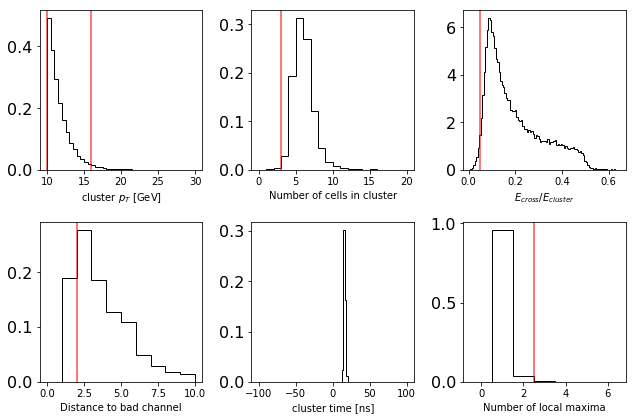

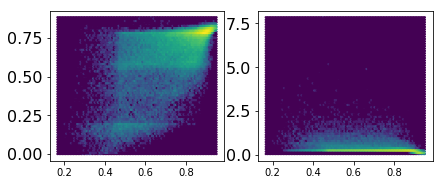

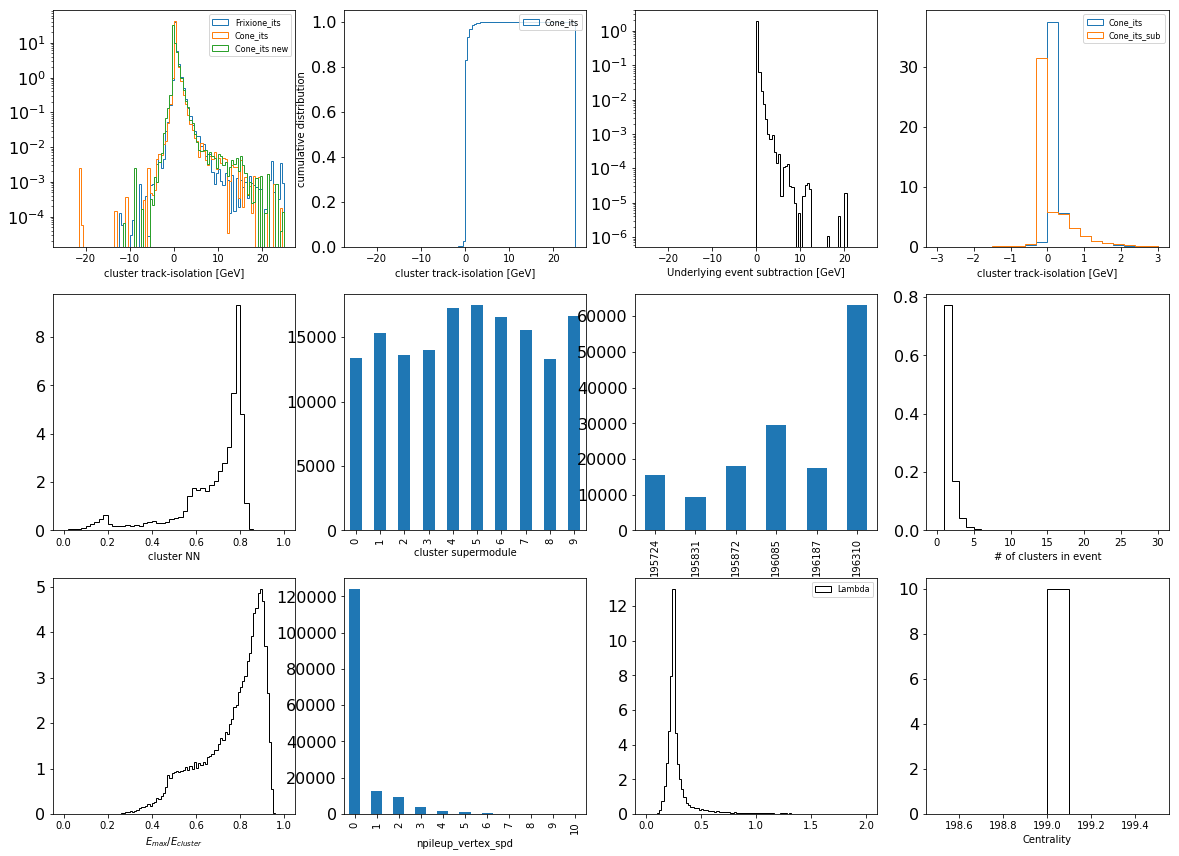

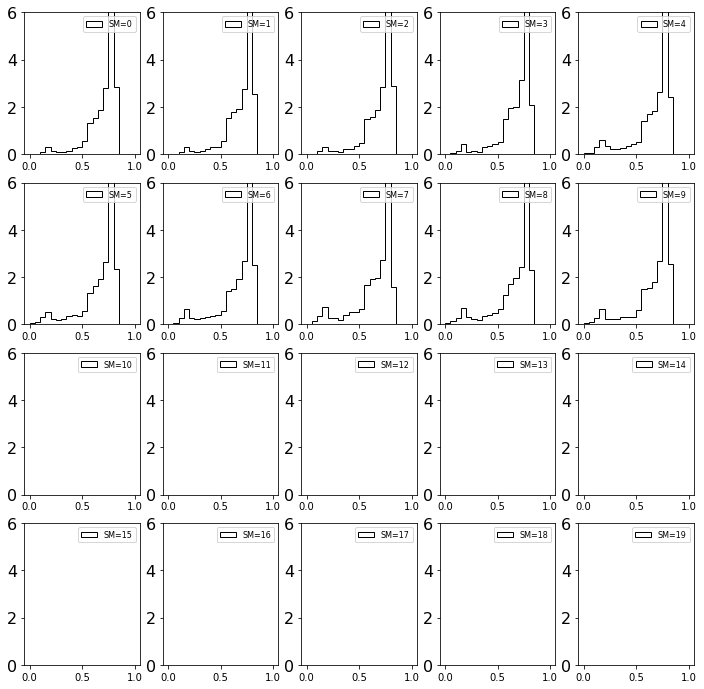

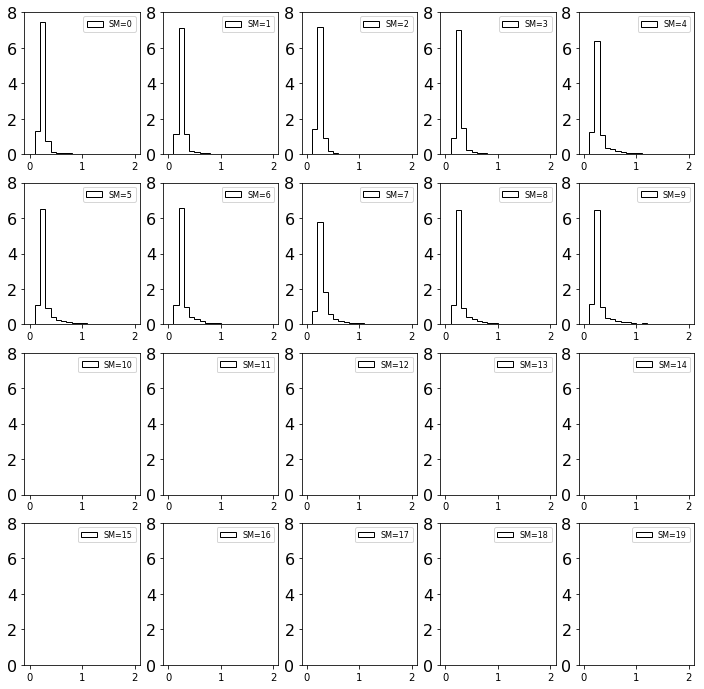

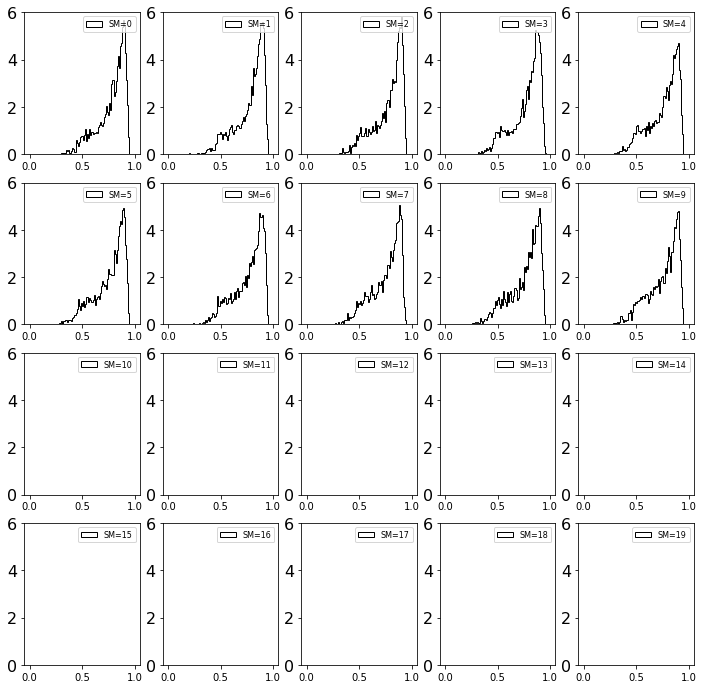

Processed 16c3c_pthat1to2_small.root in 16.5743591785 seconds
All: 261040
is_pileup_from_spd_5_08: False 261015  (99.99  %)
pt >10.0  GeV : 198171  (75.92  %)
pt <16.0  GeV : 193490  (97.64  %)
|eta| < 0.67 : 193437  (99.97  %)
ncell > 2: 192726  (99.63  %)
ecross/e > 0.05 : 189168  (98.15  %)
Distance to bad channel >= 2.0 : 153461  (81.12  %)
Local Maxima < 3 : 153098  (99.76  %)
# of isolated clusters:
cluster_iso_its_04_sub < 3 GeV: 151869  (99.20  %)
cluster_iso_its_04_sub < 2.5 GeV: 151203  (98.76  %)
cluster_iso_its_04_sub < 2 GeV: 149899  (97.91  %)
cluster_iso_its_04_sub < 1 GeV: 140822  (91.98  %)
Fraction of clusters that have iso==0
cluster_iso_its_04==0 94884  (61.98  %)
cluster_iso_its_04_sub==0 1629  (1.06  %)
out of the isolated data
cluster_iso_its_04==0 94884  (67.38  %)


/root/anaconda2/lib/python2.7/site-packages/root_pandas/readwrite.py:181: FutureWarning:  The option flatten=True is deprecated. Please specify the branches you would like to flatten in a list: flatten=['foo', 'bar']
  "to flatten in a list: flatten=['foo', 'bar']", FutureWarning)
/root/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:817: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bins


In [10]:
##mcFiles = ['17g6a1_pthat2_clusterv1_small.root']
#mcFiles =['18b10ab_calo_pthat1to2_small.root']
mcFiles = ['16c3c_pthat1to2_small.root']
#mcFiles = ['16c3c_pthat2_small.root']

mcFullHists = getData(mcFiles)
print 'All:', mcFullHists.shape[0]
mcHists = applyCuts(mcFullHists, mcFiles[0],isMC=True)
plt.show()
##print 'After All cuts:', mcHists.shape[0]

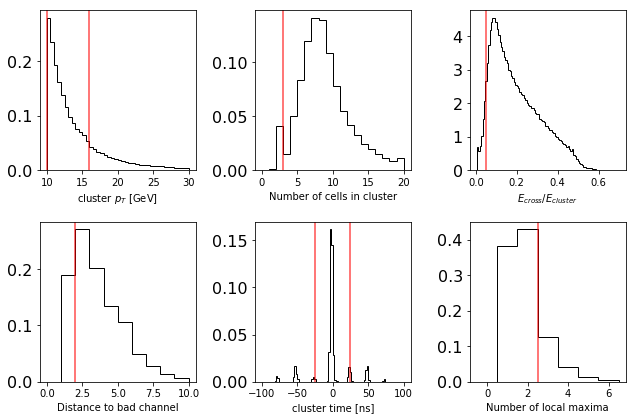

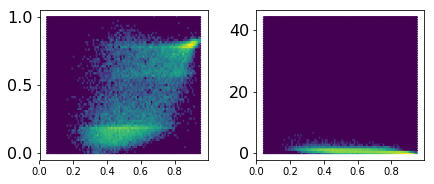

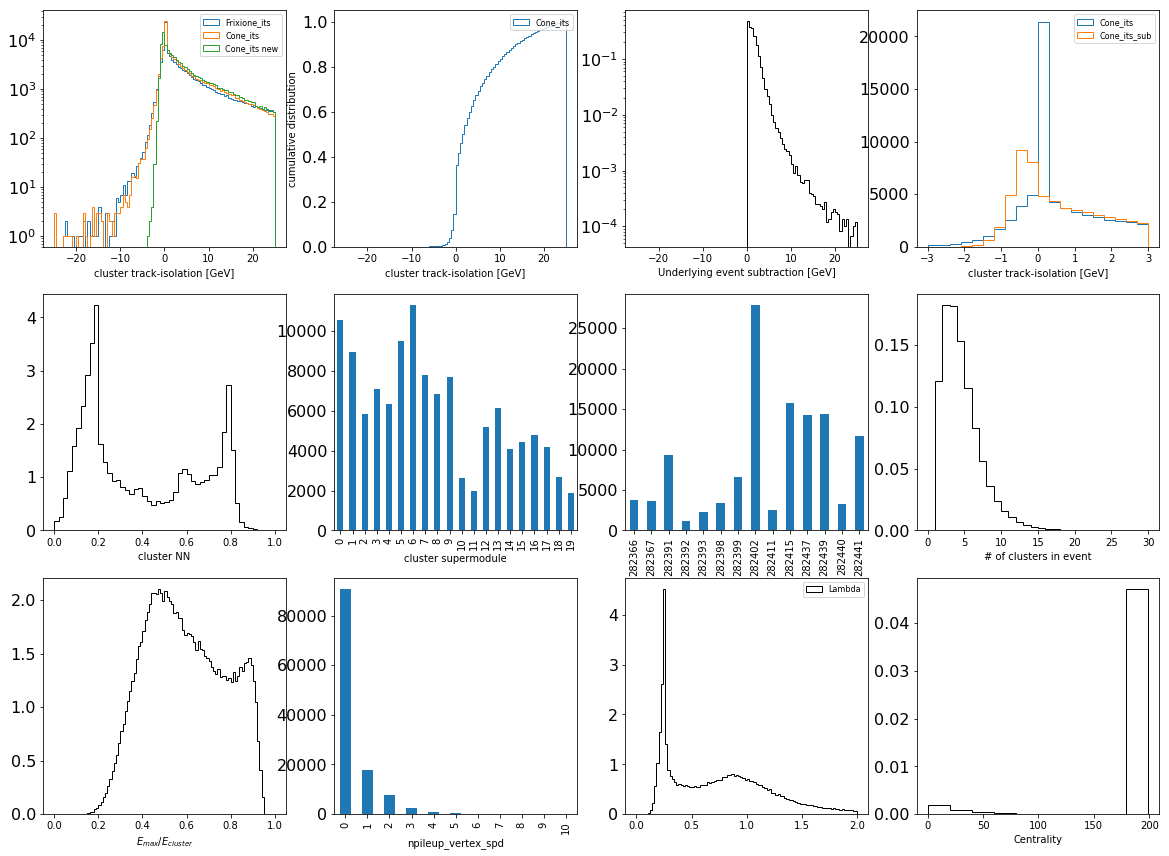

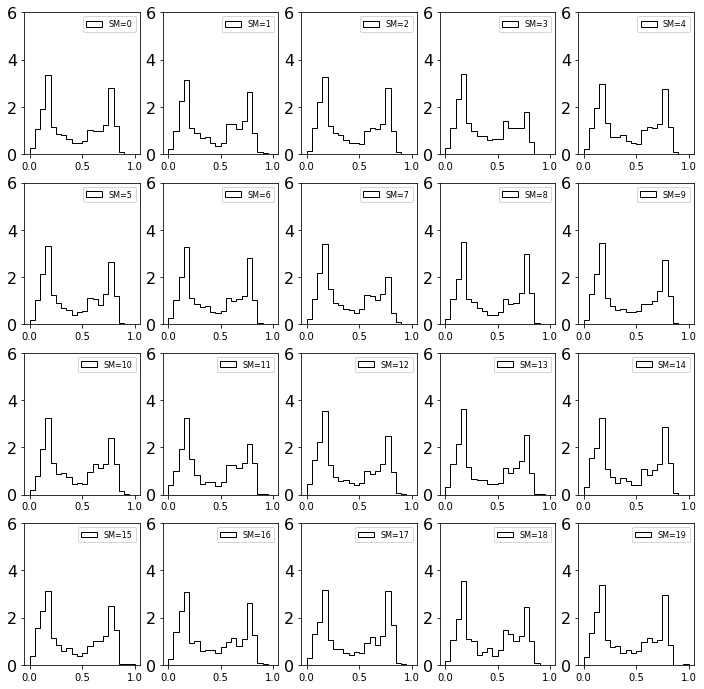

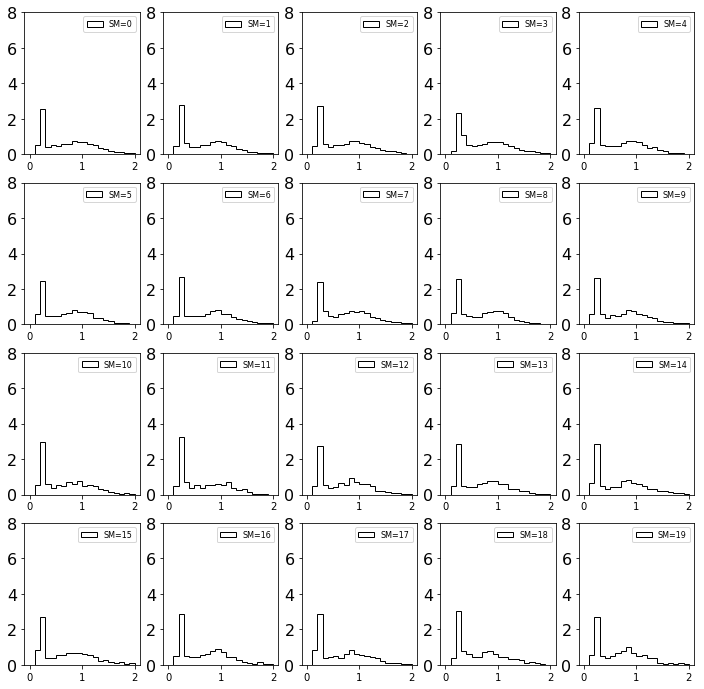

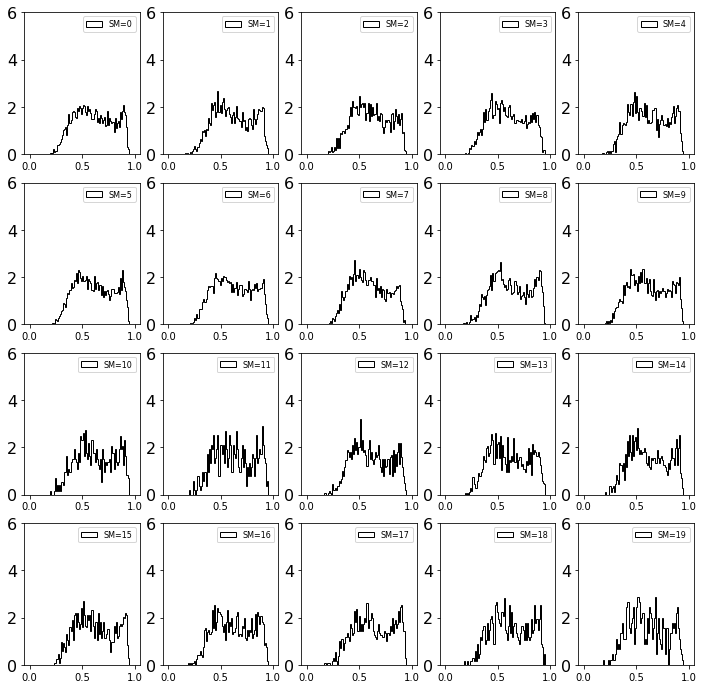

Processed 17q_CENT_wSDD_4L_small.root in 30.5466771126 seconds
All: 1637750
After droping rows with NA values: 1637750
is_pileup_from_spd_5_08: False 1368013  (83.53  %)
pt >10.0  GeV : 322841  (23.60  %)
pt <16.0  GeV : 237328  (73.51  %)
|eta| < 0.67 : 237282  (99.98  %)
ncell > 2: 227303  (95.79  %)
ecross/e > 0.05 : 215160  (94.66  %)
Distance to bad channel >= 2.0 : 179293  (83.33  %)
|cluster time| < 30 [ns] 147451  (82.24  %)
Local Maxima < 3 : 119887  (81.31  %)
# of isolated clusters:
cluster_iso_its_04_sub < 3 GeV: 57890  (48.29  %)
cluster_iso_its_04_sub < 2.5 GeV: 54020  (45.06  %)
cluster_iso_its_04_sub < 2 GeV: 49518  (41.30  %)
cluster_iso_its_04_sub < 1 GeV: 39118  (32.63  %)
Fraction of clusters that have iso==0
cluster_iso_its_04==0 16588  (13.84  %)
cluster_iso_its_04_sub==0 49  (0.04  %)
out of the isolated data
cluster_iso_its_04==0 16580  (42.38  %)


In [26]:
#dataname = '5 TeV pPb'
#isMC = False
#dataFiles = ['13e_4L_small.root']
#dataFiles = ['13d4L_small.root']
#dataFiles = ['13def_small.root']

dataname = '5 TeV pp'
isMC = False
#dataFiles = ['17q_CENT_wSDD_small.root']
dataFiles = ['17q_CENT_wSDD_4L_small.root']

dataFullHists = getData(dataFiles)
print 'All:',dataFullHists.shape[0]
dataFullHists.dropna()
print 'After droping rows with NA values:',dataFullHists.shape[0]

dataHists = applyCuts(dataFullHists,dataFiles[0],isMC)
plt.show()


## Producing pseudodata with known fraction

In [ ]:
dataFiles = ['17g6a3_pthat2_small.root']
dataFullHists = getData(dataFiles) 
dataHists = applyCuts(dataFullHists) 
print 'All:',dataFullHists.shape[0] 
InjectedSignal = applyCut(mcHists, 'cluster_iso_its_04<1', 'isolation < 1 GeV:') 
print 'Injected Signal:',InjectedSignal.shape[0]

dataHists = pd.concat([dataHists ,InjectedSignal[:3000]]) 
print dataHists.shape[0]
plt.show()

In [ ]:
mcBKGFiles = ['17g6a3_pthat2_small.root']
mcBKGFullHists = getData(mcBKGFiles)
mcBKGHists = applyCuts(mcBKGFullHists)
plt.show()

##COMPARE PT SPECTRUM OF DATA AND MC

In [ ]:
fig = plt.figure(figsize=(15,6))
plt.subplot(2,3,1)
plt.hist(dataHists['cluster_pt'],range=(10,16), bins=10,histtype='step', normed=True)
plt.hist(mcHists['cluster_pt'],range=(10,16), bins=10,histtype='step',color ='purple', normed=True, weights=mcHists['weights'])

netabins = 20
plt.subplot(2,3,2)
plt.hist(dataHists['cluster_eta'],range=(-1.0,1.0), bins=netabins,histtype='step', normed=True)
plt.hist(dataHists.query('cluster_iso_its_04<1.0')['cluster_eta'],range=(-1.0,1.0), bins=netabins,histtype='step', normed=True)
plt.hist(mcHists['cluster_eta'],range=(-1.0,1.0), bins=netabins,color ='purple', histtype='step', normed=True, weights=mcHists['weights'])

nphibins = 20
plt.subplot(2,3,3)
plt.hist(dataHists['cluster_phi'],range=(-np.pi,np.pi), bins=nphibins,histtype='step', normed=True)
plt.hist(dataHists.query('cluster_iso_its_04<1.0')['cluster_phi'],range=(-np.pi,np.pi), bins=nphibins,histtype='step', normed=True)
plt.hist(mcHists['cluster_phi'],range=(-np.pi,np.pi), bins=nphibins,color ='purple', histtype='step', normed=True, weights=mcHists['weights'])

plt.show()

## NN data

In [ ]:
bins = 100
#bins =75
fitRange = (0.05, 0.88) #0.05 --0.90
xlabel = 'Deep Neural Network Output'
varname = 'cluster_NN1'
puritymin = 0.55
puritymax = 0.85
limit_yaxis = 6.1
fitRangeBKGonly=(0.0, 0.3)#(0.08, 0.23)
Range=(0.0,1.0)



## Ecross over E 

In [ ]:
bins = 80
fitRange = (0.05, 0.94) #0.05 --0.90
xlabel = 'Ecross over E'
varname = 'cluster_ecross_over_e'
puritymin = 0.01
puritymax = 0.3
limit_yaxis = 6.1
fitRangeBKGonly=(0.10, 0.4)
Range=(0.0,1.0)


## Emax over Ecluster

In [ ]:
bins = 40
fitRange = (0.0, 0.90) #0.05 --0.90
xlabel = 'Emax over E'
varname = 'cluster_emax_over_e'
puritymin = 0.75
puritymax = 0.94
limit_yaxis = 6.1
fitRangeBKGonly=(0.30, 0.45)
Range=(0.0,1.0)

## Lambda 

In [ ]:
#bins = 160
bins = 100
fitRange = (0.0, 1.5)
#xlabel = 'Lambda'
xlabel = r'$\sigma_{long}^{2}$'
varname = 'cluster_Lambda'
limit_yaxis = 13.0
puritymin = 0.0
puritymax = 0.40
fitRangeBKGonly=(0.5, 1.5)
Range=(0.0,2.0)



## Run template fit over different pt ranges

In [ ]:
isomax=1.0
nonisorange=(4,10)
isolation = 'cluster_iso_its_04_sub'
tag = dataFiles[0].split('_small')[0]+mcFiles[0].split('_small')[0]+isolation

In [ ]:

tag = dataFiles[0].split('_small')[0]+mcFiles[0].split('_small')[0]+isolation

#Set pt bins
#binedges = [10.0,11.0, 12.5, 16.0]#binedges = [10.0,16.0] #binedges = np.logspace(1.0, 1.176, num=5, base=10.0)
#binedges = [10,11.0,12.5,16.0]
binedges = [10.0,16.0]
PerSuperModule = False
nsupermodules = 10
SplitEta       = False
cutbadSM      = False

#bins =80 worked
for ipt in range(len(binedges)-1):
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    title = '%2.1f < pT < %2.1f GeV'%(ptmin, ptmax)
    maskpt_do = dataHists.cluster_pt>ptmin
    maskpt_up = dataHists.cluster_pt<ptmax
    maskdata = maskpt_do & maskpt_up 

    mcmaskpt_do = mcHists.cluster_pt>ptmin
    mcmaskpt_up = mcHists.cluster_pt<ptmax  
    maskmc   = mcmaskpt_do & mcmaskpt_up
    
    
    
    Templates = getTemplates(dataHists[maskdata], mcHists[maskmc], bins,  isocut=isomax, nonisocuts=nonisorange, 
                             var = varname,  varRange=Range, isovar=isolation)
    dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
    tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
    tf.plotFit(xlabel, title, True, puritymin, puritymax,
               normalize=False, figureFilename=varname+'ptmin%2.0f_ptmax%2.0f_%s_Iso%2.0f_Noniso%2.0f_%2.0f.pdf'%(ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))

     
        
    if(cutbadSM):
        dataveto = dataHists.cluster_SuperModule!=3
        dataveto2 = dataHists.cluster_SuperModule!=7
        #veto  = maskdataRemoved & dataHists.cluster_SuperModule!=7
        mcveto =  mcHists.cluster_SuperModule!=3
        mcveto2 =  mcHists.cluster_SuperModule!=7
        #maskmcRemoved = maskmcRemoved & mcHists.cluster_SuperModule!=7

        Templates = getTemplates(dataHists[maskdata & dataveto & dataveto2],
                                 mcHists[maskmc & mcveto & mcveto2], 
                                 bins,  isocut=isomax, nonisocuts=nonisorange, var = varname,  varRange=Range, isovar=isolation)
        dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
        tf.plotFit(xlabel, title, True, puritymin, puritymax,
                   normalize=False, figureFilename=varname+'NoSM3or7_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.pdf'%(ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
    
    
    maskseta_data = [dataHists.cluster_eta>0, dataHists.cluster_eta<0]
    maskseta_mc   = [mcHists.cluster_eta>0, mcHists.cluster_eta<0]
   
    if SplitEta:
        for ieta in range(2):
            Templates = getTemplates(dataHists[maskdata & maskseta_data[ieta]], mcHists[maskmc & maskseta_mc[ieta]], bins, 
                                     isocut=isomax, nonisocuts=nonisorange, var = varname,  varRange=Range, isovar=isolation)
            dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
            tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
            tf.plotFit(xlabel, title, True, puritymin, puritymax,normalize=False,
                       figureFilename=varname+'Eta_%d_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.pdf'%(ieta,ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
    
    
    if(PerSuperModule):
        purityarray = []
        purityarrayVeto = []
        
        farray = []
        farrayVeto = []
        fErrarray = []
        fErrarrayVeto = []
        
        chi2 = []
        chi2Veto = [] 
        bins = 200
        fig = plt.figure(figsize=(24,24))
        for ism in range(nsupermodules ):
            masksm = dataHists.cluster_SuperModule==ism
            plt.subplot(2,nsupermodules/2 ,ism+1)
            plt.hist2d(dataHists[maskdata & masksm].cluster_eta, dataHists[maskdata &masksm].cluster_phi,range=([-.70, .70], [-np.pi, np.pi]),bins=100)
        plt.show()
        #fig.tight_layout()
        fig.savefig('supermodules.png')
        for ism in range(nsupermodules):
            mask_supermodules_data = dataHists.cluster_SuperModule==ism
            mask_supermodules_mc   = mcHists.cluster_SuperModule==ism
            maskdata_sm = maskdata & mask_supermodules_data
            maskmc_sm  = maskmc & mask_supermodules_mc
        
            bins = 50 #was 80
            Templates = getTemplates(dataHists[maskdata_sm], mcHists[maskmc_sm], bins,  isocut=isomax, nonisocuts=nonisorange, 
                                     var = varname,  varRange=Range, isovar=isolation)
            dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
            tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges,
                             verbosity=0, fitRange=fitRange)
            #tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, 
            #                 fitRange=fitRangeBKGonly, fixN=False,fixf=True,f0=0.0)
            tf.plotFit(xlabel, title, True, puritymin, puritymax, normalize=False,
                       figureFilename=varname+'SuperModule%d_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.pdf'%(ism,ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
        
            #Everything EXCEPT the SM = ism
            purity, pmin, pmax = tf.getPurity(puritymin, puritymax)
            purityarray.append(purity)
            farray.append(tf.fitf)
            fErrarray.append(tf.fitferr)
            chi2.append(tf.chi2/tf.dof)
            
            bins = 100
            mask_supermodules_data = dataHists.cluster_SuperModule!=ism
            mask_supermodules_mc   = mcHists.cluster_SuperModule!=ism
            maskdata_sm = maskdata & mask_supermodules_data
            maskmc_sm  = maskmc & mask_supermodules_mc
            
            Templates = getTemplates(dataHists[maskdata_sm], mcHists[maskmc_sm], bins,  isocut=isomax, nonisocuts=nonisorange,
                                     var = varname,  varRange=Range, isovar=isolation)
            dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
            tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, 
                              verbosity=0, fitRange=fitRange)
            tf.plotFit(xlabel, title, True, puritymin, puritymax, normalize=False,
                       figureFilename=varname+'VetoSuperModule%d_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.pdf'%(ism,ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
            purity, pmin, pmax = tf.getPurity(puritymin, puritymax)
            purityarrayVeto.append(purity)
            farrayVeto.append(tf.fitf)
            fErrarrayVeto.append(tf.fitferr)
            chi2Veto.append(tf.chi2/tf.dof)
            
            
           


     
            
        fig = plt.figure(figsize=(12,3))
        plt.subplot(121)
        
        plt.plot(range(nsupermodules),purityarrayVeto, marker='o')
        plt.ylim([0.0,0.5])
        
        if 'NN' in varname:
            ylabel = 'Purity with DNN fit'
        else:
            ylabel = 'Purity with Lambda fit'
            
        plt.ylabel(ylabel)
        plt.xlabel('Removed Supermodule #')
        plt.axhline(y=np.average(purityarrayVeto),color='r',label='Average =%2.1f%%'%(100.0*np.average(purityarrayVeto)))
        plt.legend(title=dataname, loc='best')
        
        plt.subplot(122)
        plt.plot(range(nsupermodules),purityarray, marker='o')
        plt.ylim([0.0,0.5])
        plt.ylabel(ylabel)
        plt.xlabel('Supermodule #')
        plt.axhline(y=np.average(purityarray),color='r',label='Average =%2.1f%%'%(100.0*np.average(purityarray)))
        plt.axhspan(np.average(purityarray)-np.std(purityarray/np.sqrt(nsupermodules)), 
                    np.average(purityarray)+np.std(purityarray)/np.sqrt(nsupermodules),color='r',
                    label='+/- RMS/sqrt(N) =%2.1f'%(100.0*np.std(purityarray)/np.sqrt(nsupermodules)), alpha=0.4)
        plt.legend(title=dataname, loc='best')

        print 'PURITY RMS = ' , np.std(purityarray)
        
        fig.tight_layout()
        plt.show()
        fig.savefig('SuperModules_SummaryPurity'+varname+tag+'.pdf')
        plt.clf()
        
        plt.subplot(121)
        plt.plot(range(nsupermodules),chi2Veto, marker='o')
        plt.ylim([0.0,3.0])
        plt.ylabel('Chi2/dof')
        plt.xlabel('Removed Supermodule #')
        plt.axhline(y=np.average(chi2Veto),color='r',label='Average')

        plt.subplot(122)
        plt.plot(range(nsupermodules),chi2, marker='o')
        plt.ylim([0.0,3.0])
        plt.ylabel('Chi2/dof')
        plt.xlabel('Supermodule #')
        plt.axhline(y=np.average(chi2),color='r',label='Average')
        
        
        plt.show()
        fig.savefig('SuperModules_SummaryPurity'+varname+tag+'.pdf')
   


              
        fig = plt.figure(figsize=(12,5))
        plt.subplot(121)
        
        plt.errorbar(range(nsupermodules),farrayVeto, yerr=fErrarrayVeto,marker='o')
        plt.ylim([0.0,1.0])
        plt.ylabel('Fraction')
        plt.xlabel('Removed Supermodule #')
        plt.axhline(y=np.average(farrayVeto),color='r',label='Average')
       # plt.show()
        #fig.savefig('supermodulesVetoFraction.png')   

        plt.subplot(122)
        #fig = plt.figure(figsize=(12,12))
        plt.errorbar(range(nsupermodules),farray, yerr=fErrarray,marker='o')
        plt.ylim([0.0,1.0])
        plt.ylabel('Fraction')
        plt.xlabel('Supermodule #')
        plt.axhline(y=np.average(farray),color='r',label='Average')
        plt.show()
        fig.savefig('SummaryFraction'+varname+tag+'.png')


In [ ]:
tf.plotTemplates(xlabel,'Templates_'+varname+'_'+tag+'.pdf')

plt.show()

# Run on test data, including bkg only fit to bkg dominated region

In [ ]:
#bins = 50 #75

nonisoranges=[(3.0,10.0), (2.0,10.0), (4.0,10.0), (3,15.0), (2.0,15.0), (4.0,15.0)]
#nonisoranges = [(3.0,10.0)]
for nonisorange in nonisoranges:
    #binedges = [10.0, 11.0,13.0,16.0]
    binedges = [10.0,16.0]
    for ipt in range(len(binedges)-1):
        ptmin = binedges[ipt]
        ptmax = binedges[ipt+1]
    
        maskpt_do = dataHists.cluster_pt>ptmin
        maskpt_up = dataHists.cluster_pt<ptmax
        maskdata = maskpt_do & maskpt_up 

        mcmaskpt_do = mcHists.cluster_pt>ptmin
        mcmaskpt_up = mcHists.cluster_pt<ptmax  
        maskmc   = mcmaskpt_do & mcmaskpt_up
    
        title = r'%2.1f < $p_{\mathrm{T}}$ < %2.1f GeV'%(ptmin, ptmax)
        Templates = getTemplates(dataHists[maskdata], mcHists[maskmc], bins,  isocut=isomax, nonisocuts=nonisorange,
                             var = varname, varRange=Range, isovar=isolation)
        dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
    #fit normally in the entire fit range
        #fitRange=(0.0, 1.0)
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
        tf.plotFit(xlabel, title, True, puritymin, puritymax, normalize=False,figureFilename=varname+'ptmin%2.0f_ptmax%2.0f_%s_Iso_%2.0f_Noniso%2.0f_%2.0f.png'%(ptmin,ptmax,tag,10.0*isomax, 10.0*nonisorange[0],10.0*nonisorange[1]))
        #fit with N float and f=0 fixed in bkg dominated region
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRangeBKGonly, fixN=False,fixf=True,f0=0.0)
        tf.plotFit(xlabel, title, False, puritymin, puritymax, normalize=False,figureFilename=varname+'ptmin%2.0f_ptmax%2.0f_%s_Iso_%2.0f_Noniso%2.0f_%2.0f_BKGONLYFIT.png'%(ptmin,ptmax,tag,10.0*isomax, 10.0*nonisorange[0],10.0*nonisorange[1]))

    #tf.plotResiduals(varname,'residualBKGOnly.png')




### Isolation fraction

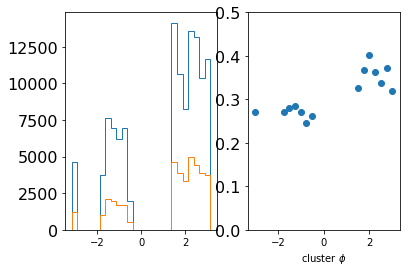

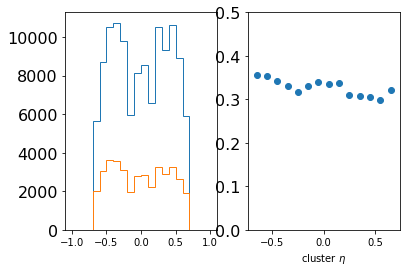

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in divide


In [27]:
fig = plt.figure()
test = dataHists
test = test.query('cluster_pt<16 and cluster_pt>10')
testiso = test.query('cluster_iso_its_04_sub<1.0')

plt.subplot(1,2,1) 

A, x, _ = plt.hist(test['cluster_phi'], range=(-np.pi, np.pi), bins=25, histtype='step')
B, x, _ = plt.hist(testiso['cluster_phi'], range=(-np.pi, np.pi), bins=25, histtype='step')

plt.subplot(1,2,2) 

AB = np.divide(B,A)

x= np.delete(x,-1)
x = np.add( x, (x[1]-x[0])/2.0 )
plt.scatter(x, AB)
plt.xlabel(r'cluster $\phi$')
plt.ylim(ymin=0.0,ymax=0.50)
plt.show()

plt.clf()
plt.subplot(1,2,1) 


A, x, _ = plt.hist(test['cluster_eta'], range=(-1.0, 1.0), bins=20, histtype='step')
B, x, _ = plt.hist(testiso['cluster_eta'], range=(-1.0, 1.0), bins=20, histtype='step')

plt.subplot(1,2,2) 

AB = np.divide(B,A)

x= np.delete(x,-1)
x = np.add( x, (x[1]-x[0])/2.0 )
plt.scatter(x, AB)
plt.xlabel(r'cluster $\eta$')
plt.ylim(ymin=0.0,ymax=0.50)
plt.show()

##Checking isolation distribution and probabilities

In [ ]:
    #plt.hist(dataframe['cluster_phi'], bins=50,color='black',histtype='step', normed=True)
    #plt.xlabel(r'cluster $\phi$')

# Isolation Sideband and signal region plots

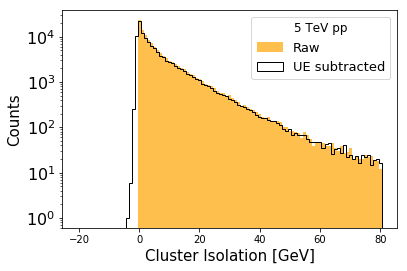

In [28]:
isotype = 'its'
isolationvar = 'cluster_iso_%s_04' %(isotype)

test = dataHists

test = test.query('cluster_pt<16 and cluster_pt>10')
maxIso = 80.5
minIso = -20.5
nbins  = 101

mpl.rcParams['legend.fontsize'] = 10
#fig = plt.figure(figsize=(8,8))
fig = plt.figure()
#plt.subplot(1,2,1)
plt.hist(test['%s_raw'%isolationvar],range=(minIso,maxIso),color='orange',bins=nbins,alpha=0.7,label='Raw')
plt.hist(test['%s_sub'%isolationvar],range=(minIso,maxIso),bins=nbins,color='black',label='UE subtracted',histtype='step')
#plt.hist(test['%s'%isolationvar],range=(minIso,maxIso),bins=nbins,color='red',label='UE subtracted (voronoi)',histtype='step')
plt.xlabel('Cluster Isolation [GeV]',fontsize=15)
plt.yscale('log', nonposy='clip')
plt.ylabel('Counts',fontsize=15)
plt.legend(title=dataname,fontsize=13)



#plt.subplot(1,2,2)
#plt.hist(test['%s_ue'%isolationvar],range=(0.0,10),bins=nbins,alpha=0.5, label='rho x area voronoi')
#plt.hist(test['ue_estimate_its_const']*0.4*0.4*3.14,range=(0.0,10),bins=nbins,alpha=0.5, label='rho x area')
#plt.text(5, 50000, 'UE Average = %2.1f [GeV]'%(np.average(test['%s_ue'%isolationvar])), fontsize=12)
#plt.legend()
#plt.text(5, 40000, 'UE Average = %2.1f [GeV]'%(np.average(test['ue_estimate_its_const*0.4*0.4*3.14'])), fontsize=12)

plt.show()
fig.tight_layout()

fig.savefig('IsolationWithUESubtraction_%s.pdf'%dataFiles[0].split('_small')[0])


# Isolation Sideband and signal region plots

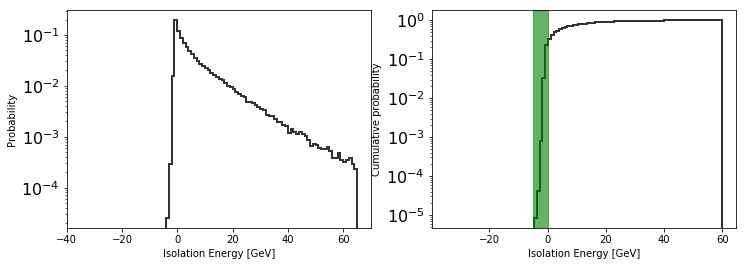

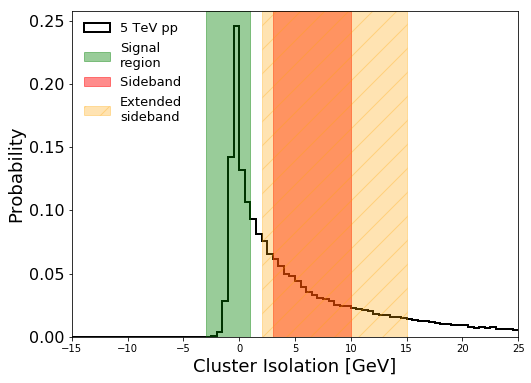

In [38]:
# Build templates from dataframes
isolationvar = 'cluster_iso_its_04_sub'
#isolationvar = 'cluster_frixione_its_04_02'
#test = dataHists.query('%s<200'%isolationvar)
test = test.query('cluster_pt<16 and cluster_pt>10')

mpl.rcParams['legend.fontsize'] = 15

fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(test[isolationvar],bins=100,range=(-35, 65),label='Data',normed=True,alpha=0.8,histtype='step',linewidth=2,color='black')
plt.xlabel('Isolation Energy [GeV]')
plt.ylabel('Probability')
plt.yscale('log', nonposy='clip')
plt.subplot(1,2,2)
plt.hist(test[isolationvar],bins=100,range=(-35, 60),label='ola', cumulative=True, normed=True,alpha=0.8,histtype='step',linewidth=2,color='black')
plt.xlabel('Isolation Energy [GeV]')
plt.ylabel('Cumulative probability')
plt.yscale('log', nonposy='clip')
plt.axvspan(-5,0.0, color='green', alpha=0.6,label='Signal region')

plt.show()
#fig.tight_layout()
mpl.rcParams['legend.fontsize'] = 13

#fig.savefig('IsolationSideband.png')

#fig = plt.figure(figsize=(10,5))



#mpl.rcParams.update({'xtick.labelsize': 16}) 

fig = plt.figure(figsize=(8,6))
plt.hist(test[isolationvar],bins=200, range=(-35.5, 64.5), label=dataname,normed=True,histtype='step',linewidth=2,color='black')
plt.xlabel('Cluster Isolation [GeV]',fontsize=18)
plt.axvspan(-3,1.0, color='green', alpha=0.4,label='Signal\nregion')
plt.axvspan(3,10, color='red', alpha=0.450,label='Sideband ')
plt.axvspan(2,15, color='orange', alpha=0.3,label='Extended\nsideband',hatch="/")
plt.legend(loc='upper left',frameon=False)
plt.ylabel('Probability',fontsize=18)
#plt.hist(test[isolationvar],bins=181, range=(-35.5, 65.5), label='Data',normed=True,histtype='step',linewidth=2,color='black')

#plt.yscale('log', nonposy='clip')

plt.xlim([-15.0,+25.0])

plt.show()
fig.tight_layout()
fig.savefig('IsolationSideband_limited_%s.pdf'%dataFiles[0].split('_small')[0])


## sideband variatio

In [ ]:
#test[test.cluster_frixione_its_04_02<2].hist(column='cluster_NN1',bins=40,label='ola',normed=True)
mpl.rcParams.update({'legend.fontsize': 8})
fig = plt.figure(figsize=(12,8))


isolationvar = 'cluster_iso_its_04_sub'

test = dataHists.query('cluster_pt<16 and cluster_pt>10')


limits =  [ (3.0,15.0), (2.0,10.0), (2.0,15.0), (4.0,10.0), (4.0,15.0)]
nrows = 2
ncolumns = 3
nbins = 80



for lim in limits:
    plt.subplot(nrows,ncolumns,1)
    mask1 = test.cluster_iso_its_04_sub>lim[0]
    mask2 = test.cluster_iso_its_04_sub<lim[1]
    mask = mask1 & mask2
    tag = '%2.1f<Iso<%2.1f GeV'%(lim[0],lim[1])
    plt.hist(test[mask]['cluster_NN1'], linewidth=2.0,bins=80,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel('cluster NN1 ')


    plt.subplot(nrows,ncolumns,3)
    plt.hist(test[mask]['cluster_Lambda'],linewidth=2.0, range=(0,2), bins=nbins,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel('cluster lambda ')

    plt.subplot(nrows,ncolumns,4)
    plt.hist(test[mask]['cluster_emax_over_e'],linewidth=2.0, range=(0,1), bins=nbins,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel('Emax/Ecluster')
    
    plt.subplot(nrows,ncolumns,5)
    plt.hist(test[mask]['cluster_pt'],linewidth=2.0, bins=20,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel('cluster pt [GeV]')
    plt.subplot(nrows,ncolumns,6)
    plt.hist(test[mask]['cluster_ncell'],linewidth=2.0, range=(0,20), bins=nbins,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel('Number of cells in cluster')

plt.legend()
#fig.savefig('IsolationCorrelation%s.png'%dataFiles[0].split('_small')[0])

plt.show()

plt.clf()
fig = plt.figure(figsize=(12,6))


mask1 = test.cluster_iso_its_04_sub>3.0
mask2 = test.cluster_iso_its_04_sub<10.0
plt.subplot(1,2,2)
plt.hist(test[mask]['cluster_NN1'],  linewidth=3.0, color='black', bins=nbins,label='Nominal,3<Iso<10 GeV',
         normed=True,alpha=0.8,histtype='step',linestyle='--')
plt.subplot(1,2,1)
plt.hist(test[mask]['cluster_Lambda'], linewidth=3.0, color='black', range=(0,2), bins=nbins,label='Nominal, 3<Iso<10 GeV',
         normed=True,alpha=0.8,histtype='step',linestyle='--')
plt.xlabel(r'$\sigma_{long}^{2}$', fontsize=16)
plt.ylabel('probability ', fontsize=16)

for lim in limits:
    plt.subplot(1,2,2)
    mask1 = test.cluster_iso_its_04_sub>lim[0]
    mask2 = test.cluster_iso_its_04_sub<lim[1]
    mask = mask1 & mask2
    tag = '%2.1f<Iso<%2.1f GeV'%(lim[0],lim[1])
    plt.hist(test[mask]['cluster_NN1'], linewidth=1.0,bins=nbins,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel('Deep Neural Network ', fontsize=16)
    plt.ylabel('probability ', fontsize=16)



    plt.subplot(1,2,1)
    plt.hist(test[mask]['cluster_Lambda'],linewidth=2.0, range=(0,2), bins=nbins,label=tag,normed=True,alpha=0.7,histtype='step')
    plt.xlabel(r'$\sigma_{long}^{2}$', fontsize=16)
    plt.ylabel('probability ', fontsize=16)


plt.legend(title=dataname, fontsize=14)
plt.show()
fig.tight_layout()
fig.savefig('IsolationCorrelation%s.pdf'%dataFiles[0].split('_small')[0])

test = test.query('%s>1'%isolationvar)

print ' Correlation coefficients: '
print '%20s %2.2f'%('Iso and pt',test[isolationvar].corr(test['cluster_pt']))
print '%20s %2.2f'%('Iso and NN1',test[isolationvar].corr(test['cluster_NN1']))
print '%20s %2.2f'%('Iso and Lambda',test[isolationvar].corr(test['cluster_Lambda']))


print '%20s %2.2f'%('Iso and Ecross/E',test[isolationvar].corr(test['cluster_ecross_over_e']))
print '%20s %2.2f'%('Iso and Ncell',test[isolationvar].corr(test['cluster_ncell']))



In [ ]:
print 'Correlation between Iso and pt %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_pt'])
print 'Correlation between Iso and NN1 %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_NN1'])
print 'Correlation between Iso and Lambda %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_Lambda'])


print 'Correlation between Iso and ncell %2.2f'%test['cluster_frixione_its_04_02'].corr(test['cluster_ncell'])



In [ ]:
calculateFitUncertainty(dataiso, signalmc, datanoniso, binEdges, puritymin, puritymax, fitRange)

In [ ]:
# vary data with poisson distribution in each bin
_ = getFitResults(varyWithinBins(dataiso, 10000), [signalmc], [datanoniso], binEdges,
                         pmin=puritymin, pmax=puritymax, verbosity=0, showDistributions=True)

In [ ]:
plotFitUncertaintyExamples(dataiso, dataisoerr, signalmc, datanoniso, binEdges)

In [ ]:
closureResults = checkClosureOverParameters(dataiso, signalmc, datanoniso, binEdges, 1000)

In [ ]:
plotCheckClosureResults(*closureResults)

# Check effect of binning

In [ ]:
def checkBinEffects(dataHists, mcHists, var, puritymin, puritymax, title,isocut, nonisocuts,isovar, fitRange=None, 
                    varRange=(0.0, 1.0)):
    dataisos, dataisoerrs = [], []
    signalmcs, signalmcerrs = [], []
    datanonisos, datanonisoerrs = [], []
    binEdgess = []        
    bins, fracs, fracerrs, purs = [], [], [], []
    reduced_chi2= []
    
    for nBins in range(20, 201,4):
        #dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = getTemplates(dataHists, mcHists, nBins,
        #var=var)
        
        #tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, 
        #                 datanonisoerr, binEdges, verbosity=0, fitRange=fitRange)
        
        Templates = getTemplates(dataHists, mcHists, nBins,  isocut=isomax, nonisocuts=nonisorange, 
                                 var = var,  varRange=varRange, isovar=isolation)
        dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, verbosity=0, fitRange=fitRange)
        bins.append(nBins)
        fracs.append(tf.fitf)
        fracerrs.append(tf.fitferr)
        purs.append(tf.getPurity(puritymin, puritymax)[0])
        reduced_chi2.append(tf.chi2/tf.dof)
        if (nBins%10 == 0 and nBins <= 100):
            dataisos.append(dataiso)
            dataisoerrs.append(dataisoerr)
            signalmcs.append(signalmc)
            signalmcerrs.append(signalmcerr)
            datanonisos.append(datanoniso)
            datanonisoerrs.append(datanonisoerr)
            binEdgess.append(binEdges)
            
#     plt.figure(figsize=(18,18))
#     for i, (dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges) \
#     in enumerate(zip(dataisos, dataisoerrs, signalmcs, signalmcerrs, datanonisos, datanonisoerrs, binEdgess)):
#         plt.subplot(3,3,i+1)plt.figure(figsize=(18,18))
#         ax = plt.gca()
#         tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, verbosity=0, fitRange=fitRange)
#         tf.plotFit('', '', newFigure=False)
#         ax.legend_.remove()
#         ax.set_ylabel('')
#         ax.set_title('nBins: %i, frac: %2.2f, purity: %2.2f'%(len(binEdges)-1,
#                                                               tf.fitf, tf.getPurity(puritymin, puritymax)[0]))
#         ax.title.set_size(16)
#         ax.tick_params(labelsize=12)

    fig = plt.figure()
    #plt.errorbar(bins, fracs, fracerrs, fmt='ko', label='Fit signal fraction')
    plt.plot(bins, fracs,  'o', label='Fit signal fraction')

    plt.plot(bins, purs, 'bd', label='Purity')
    plt.xlabel('Number of bins',fontsize=15)
    plt.ylim([0.0, 0.5])
    plt.legend(loc='best', fontsize=15, numpoints=1)
    plt.title(title,fontsize=15)
    fig.tight_layout()
    fig.savefig('Binning_purity_%s.pdf'%title) 

    ax = plt.gca()
    #ax.axhspan(np.mean(purs)-0.02, np.mean(purs)+0.02, color='green', alpha=0.2)
    
    plt.show()
    
    fig = plt.figure()
    plt.plot(bins, reduced_chi2,'-o')
    plt.ylabel(r'$\chi^{2}$/dof', fontsize=15)
    plt.xlabel('Number of bins',fontsize=15)
    plt.ylim(ymin=0.0)
    plt.title(title,fontsize=15)
    plt.legend(loc='best', fontsize=15, numpoints=1)
    plt.show()
    fig.tight_layout()
    fig.savefig('Binning_chi2_%s.pdf'%title) 

    
    
    

In [ ]:
isomax=1.0
nonisorange=(3,10)
isolationvar = 'cluster_iso_its_04_sub'


checkBinEffects(dataHists, mcHists, 'cluster_NN1', 0.5, 0.85, 'DNN',  varRange=(0,1.0), isocut=isomax, 
                nonisocuts=nonisorange, isovar=isolationvar, fitRange= (0.05, 0.88))

checkBinEffects(dataHists, mcHists, 'cluster_Lambda', 0.0, 0.40, 'Lambda',  varRange=(0,2.0), isocut=isomax, 
                nonisocuts=nonisorange, isovar=isolationvar, fitRange=(0.0, 1.5))

In [ ]:
checkBinEffects(dataHists, mcHists, 'cluster_Lambda', 0.0, 0.40, '$\lambda$', None, varRange=(0.0, 2.0))

In [ ]:
#directory = 'v2-noue-old/'
directory = 'v1-ue-new/'

mcFile = directory + 'mcdata.csv'
dataFile = directory + 'data.csv'

mcdf = pd.read_csv(mcFile)
datadf = pd.read_csv(dataFile)

ptmin = 10
ptmax = 12

def applyCut(inputDataframe, cut, text=None):
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0]
    return cutDataframe

print 'Full MC events:', mcdf.shape[0]
mcHists = applyCut(mcdf, 'cluster_pt>%f and cluster_pt<%f'%(ptmin, ptmax), '%2.1f < pt < %2.1f GeV:'%(ptmin, ptmax))

print 'Full data events:', datadf.shape[0]
dataHists = applyCut(datadf, 'cluster_pt>%f and cluster_pt<%f'%(ptmin, ptmax), '%2.1f < pt < %2.1f GeV:'%(ptmin, ptmax))

In [ ]:
import random

random.sample(range(10), 10)

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.hist(dataHists['cluster_iso_its_04'], range=(-5,25), bins=30,label='Cone_its',histtype='step')
plt.hist(dataHists['cluster_iso_its_04_sub'], range=(-5,25), bins=30,label='cluster_frixione_its_04_02',histtype='step')
#plt.axvline(x=2.0, color='r')
#plt.axvline(x=5.0, color='g')
#plt.yscale('log', nonposy='clip')
plt.legend(loc='best')
plt.xlabel('cluster track-isolation [GeV]')
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.hist(dataHists['ue_estimate_its_const'], range=(0,25), bins=100,label='rho',histtype='step')
plt.legend(loc='best')
plt.xlabel('rho (GeV)')
plt.show()
